Following and simplifying the toy example in Section 5.1 of Karagiannis / Andrieu, 2013.

In [1]:
import numpy as np
from scipy.stats import norm
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

class Target():
    def __init__(self):
        self.models = [self.model_1d_log_pdf, self.model_2d_log_pdf]
        self.dimensions = [1, 2]
        self._dimension_matching_proposal = norm(loc=0, scale=1)
    
    def model_1d_log_pdf(self, x):
        """double-well in 1D"""
        return -np.abs(np.abs(float(x))**2 - 2)**2

    def model_2d_log_pdf(self, x):
        """quad-well in 2D"""
        return self.model_1d_log_pdf(x[0] * 2) + self.model_1d_log_pdf(x[1] * 2)

    def log_pdf(self, x, k=0):
        """x is a vector or scalar, k is a model index"""
        return self.models[k](x)
    
    def sample_extra_dimension(self):
        u = self._dimension_matching_proposal.rvs()
        return u
    
    def dimension_matching_proposal_log_pdf(self, x):
        return self.model_1d_log_pdf(x[0]) + self._dimension_matching_proposal.logpdf(x[1])
    
target = Target()
target.log_pdf(np.random.randn(2), 1)

-6.6129981521785695

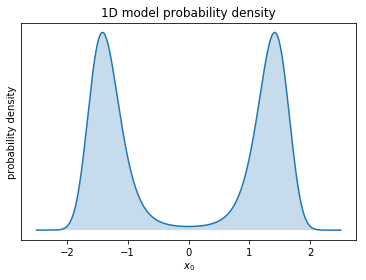

In [58]:
xs = np.linspace(-2.5, 2.5, 10000)
ys = np.exp(np.array([target.log_pdf(x, k=0) for x in xs]))
plt.plot(xs, ys)
plt.fill_between(xs, ys, alpha=0.25)

plt.xlabel(r'$x_0$')
plt.ylabel('probability density')
plt.yticks([])
plt.title('1D model probability density')
plt.savefig('model_1d_pdf.jpg', dpi=300)

In [107]:
xs_1d = np.linspace(-1.25, 1.25, 1000)
ys_1d = np.exp(np.array([target.log_pdf(x*2, k=0) for x in xs_1d]))
ys_2d = np.outer(ys_1d, ys_1d)

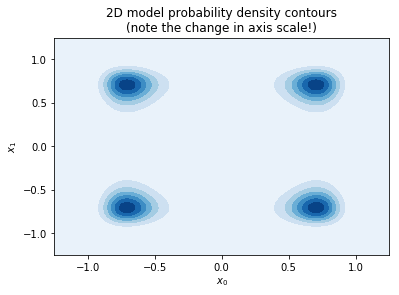

In [108]:
plt.contourf(xs_1d, xs_1d, ys_2d, cmap="Blues")
plt.xlabel(r'$x_0$')
plt.ylabel(r'$x_1$')
plt.title('2D model probability density contours\n(note the change in axis scale!)')
plt.savefig('model_2d_pdf_contours.jpg', dpi=300)

In [7]:
class Rho():
    def __init__(self, target):
        self.target = target
        
    def log_pdfs_at_endpoints(self, x, k1=0, k2=1):
        # restrict x to the dimensions of the models k1 and k2
        x_model_k1 = x[:self.target.dimensions[k1]]
        x_model_k2 = x[:self.target.dimensions[k2]]
        
        # log probabilities under the two target models
        log_prob_k1 = target.log_pdf(x_model_k1, k1)
        log_prob_k2 = target.log_pdf(x_model_k2, k2)
        
        return log_prob_k1, log_prob_k2
    
    def log_pdf(self, x, k1=0, k2=1, tempering_time=0.0):
        
        log_prob_k1, log_prob_k2 = self.log_pdfs_at_endpoints(x, k1, k2)
        
        # dimension matching proposal
        if k1 != k2:
            log_dimension_match_proposal = target.dimension_matching_proposal_log_pdf(x)
        else:
            log_dimension_match_proposal = 0
        
        return (1 - tempering_time) * (log_prob_k1 + log_dimension_match_proposal) + (tempering_time) * (log_prob_k2 + log_dimension_match_proposal)
rho = Rho(target)
        
# To-do: some sanity checks that rho.log_pdf() gives me the right behavior at end-points

# To-do: modify constructor to accept a Markov kernel, instead of hard-coding one

In [8]:
class AISRJ():
    def __init__(self, rho, T, N=1, proposal_sigma=0.1):
        """
        Parameters
        ----------
        rho: instance of Rho
        T: int
        N: int
        proposal_sigma: float
        """
        self.rho = rho
        self.T = T
        self.N = N
        self.proposal_sigma = 0.1
        
    def annealing_update_sweep(self, x, k1=0, k2=1, annealing_time=0.0):
        """
        Returns
        -------
            x: vector
            acceptance probability: float
            accepted: boolean
        """
        # for now, hard-coding to use random-walk metropolis-hastings
        
        
        
        # draw a proposal
        x_proposed = x + np.random.randn(len(x)) * self.proposal_sigma
        
        # compute log rho density at x and x_proposal
        log_rho = rho.log_pdf(x, k1, k2, annealing_time)
        log_rho_proposed = rho.log_pdf(x_proposed, k1, k2, annealing_time)
        
        # here, probability of forward proposal = probability of reverse proposal, so we don't have to include it
        acceptance_probability = np.exp(min(0, log_rho_proposed - log_rho))
        if np.random.rand() < acceptance_probability:
            return (x_proposed, acceptance_probability, True)
        else:
            return (x, acceptance_probability, False)
        
    def log_importance_weight(self, x, k1=0, k2=1):
        log_prob_k1, log_prob_k2 = self.rho.log_pdfs_at_endpoints(x, k1, k2)
        return log_prob_k2 - log_prob_k1
    
    def run_ais_rj(self, x_initial, k_initial, n_iterations=1000):
        
        x = x_initial
        k1 = k_initial
        
        log_acceptance_probabilities = {(0,0): [], (0,1): [], (1,0): [], (1,1): []}
        trajectory = [(x, k1)]
        
        for i in tqdm(range(n_iterations)):
            
            x_ais = np.array(x)
            
            # draw a model label to attempt to jump to
            k2 = np.random.randint(len(self.rho.target.models))

            # dimension-matching step
            if k1 == 0 and k2 == 1:
                x_ais = np.zeros(2)
                x_ais[0] = x[0]
                x_ais[1] = self.rho.target.sample_extra_dimension()
            elif k1 == 0 and k2 == 0:
                x_ais = np.array(x[:1])
            elif k1 == 1:
                x_ais = np.array(x)

            # annealing importance weight
            log_AIW = self.log_importance_weight(x_ais, k1, k2) / self.T

            # annealing
            for t in range(1, self.T):
                annealing_time = float(t) / self.T
                for n in range(self.N):
                    (x_ais, acceptance_probability, accepted) = self.annealing_update_sweep(x_ais, k1, k2, annealing_time)
                log_AIW += self.log_importance_weight(x_ais, k1, k2) / self.T
            
            # RJ accept / reject
            log_acceptance_probability_rj = min(0, log_AIW)
            log_acceptance_probabilities[(k1, k2)].append(log_acceptance_probability_rj)
            
            acceptance_probability_rj = np.exp(log_acceptance_probability_rj)
            
            
            if np.random.rand() < acceptance_probability_rj:
                #print('{}: accepted a move ({} --> {})!'.format(i, k1, k2))
                k1 = k2
                dim = self.rho.target.dimensions[k1]
                x = x_ais[:dim]
                
            trajectory.append((x, k1))
        return trajectory, log_acceptance_probabilities    

In [11]:
ais_rj = AISRJ(T=2, N=2, rho=rho)

In [13]:
trajectory, log_acceptance_probabilities = ais_rj.run_ais_rj(np.random.randn(1), 0, n_iterations=10000)

100%|██████████| 10000/10000 [00:03<00:00, 2765.09it/s]


In [109]:
np.min(log_acceptance_probabilities[(0,1)]), np.max(log_acceptance_probabilities[(0,1)])

(-2337.284812478618, 0.0)

In [17]:
mean_acceptance_probability = np.zeros((2,2))
for i in range(2):
    for j in range(2):
        mean_acceptance_probability[i,j] = np.mean(np.exp(log_acceptance_probabilities[(i,j)]))

In [18]:
mean_acceptance_probability

array([[1.        , 0.0287084 ],
       [0.49671451, 1.        ]])

In [19]:
# estimated Bayes factor
mean_acceptance_probability[0,1] / mean_acceptance_probability[1,0]

0.05779657630544113

(array([1.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 9.000e+00,
        8.000e+00, 3.400e+01, 1.110e+02, 4.622e+03]),
 array([-2737.53900064, -2463.78510058, -2190.03120051, -1916.27730045,
        -1642.52340039, -1368.76950032, -1095.01560026,  -821.26170019,
         -547.50780013,  -273.75390006,     0.        ]),
 <a list of 10 Patch objects>)

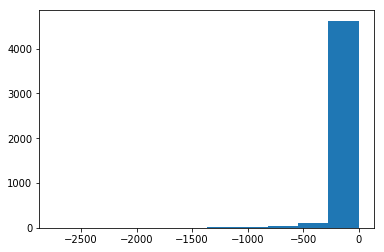

In [20]:
plt.hist(log_acceptance_probabilities[(0,1)])

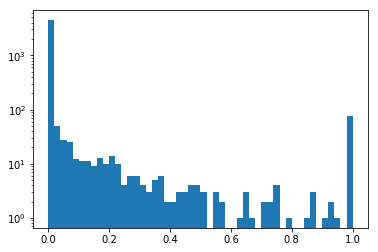

In [21]:
plt.hist(np.exp(log_acceptance_probabilities[(0,1)]), bins=50)
plt.yscale('log')

In [22]:
# counting estimate of the Bayes factor
float(sum([t[1]==1 for t in trajectory])) / float(sum([t[1]==0 for t in trajectory]))

0.054068296795952785

In [23]:
sum([t[1]==1 for t in trajectory]), sum([t[1]==0 for t in trajectory])

(513, 9488)

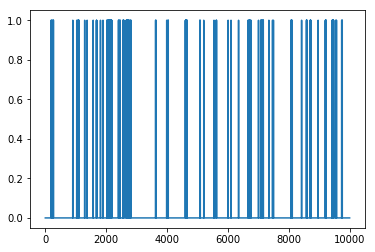

In [24]:
plt.plot([t[1] for t in trajectory])

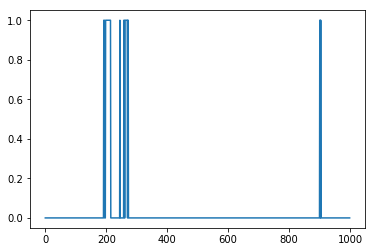

In [25]:
plt.plot([t[1] for t in trajectory][:1000])

In [26]:
ais_rj = AISRJ(T=100, N=1, rho=rho)
trajectory, log_acceptance_probabilities = ais_rj.run_ais_rj(np.random.randn(2), 1, 1000)

100%|██████████| 1000/1000 [00:16<00:00, 59.14it/s]


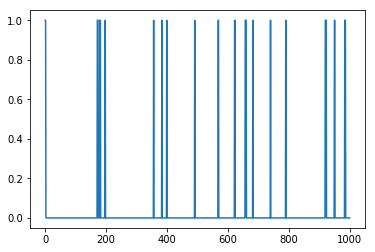

In [27]:
plt.plot([t[1] for t in trajectory])

In [28]:
mean_acceptance_probability = np.zeros((2,2))
for i in range(2):
    for j in range(2):
        mean_acceptance_probability[i,j] = np.mean(np.exp(log_acceptance_probabilities[(i,j)]))
mean_acceptance_probability

array([[1.        , 0.02995688],
       [0.97484419, 1.        ]])

In [29]:
# bridge-sampling estimate of the Bayes factor
mean_acceptance_probability[0,1] / mean_acceptance_probability[1,0]

0.030729917905482577

In [30]:
def estimate_bayes_factor(T=1, N=1, n_iterations=1000):
    """use bridge-sampling identity rather than counting"""
    ais_rj = AISRJ(T=T, N=N, rho=rho)
    trajectory, log_acceptance_probabilities = ais_rj.run_ais_rj(np.ones(1), 0, n_iterations=n_iterations)
    mean_acceptance_probability = np.zeros((2,2))
    for i in range(2):
        for j in range(2):
            mean_acceptance_probability[i,j] = np.mean(np.exp(log_acceptance_probabilities[(i,j)]))
    bayes_factor = mean_acceptance_probability[0,1] / mean_acceptance_probability[1,0]
    
    return trajectory, log_acceptance_probabilities, bayes_factor

In [33]:
np.random.seed(0)
results = []

n_iterations = 10000
Ts = [1] + list(range(10,101))[::10]

for T in Ts:
    N = 1
    trajectory, log_acceptance_probabilities, bayes_factor = estimate_bayes_factor(T, N, n_iterations)
    results.append((trajectory, log_acceptance_probabilities, bayes_factor))
    print('bayes_factor estimated at T={}: {:.3f}'.format(T, bayes_factor))

  1%|          | 74/10000 [00:00<00:13, 738.58it/s]

bayes_factor estimated at T=1: 0.011


  0%|          | 27/10000 [00:00<00:38, 260.07it/s]

bayes_factor estimated at T=10: 0.057


  0%|          | 20/10000 [00:00<00:50, 198.70it/s]

bayes_factor estimated at T=20: 0.052


  0%|          | 14/10000 [00:00<01:12, 138.34it/s]

bayes_factor estimated at T=30: 0.047


  0%|          | 10/10000 [00:00<01:50, 90.16it/s]

bayes_factor estimated at T=40: 0.044


  0%|          | 9/10000 [00:00<01:51, 89.30it/s]

bayes_factor estimated at T=50: 0.039


  0%|          | 7/10000 [00:00<02:36, 63.83it/s]

bayes_factor estimated at T=60: 0.038


  0%|          | 5/10000 [00:00<03:38, 45.79it/s]

bayes_factor estimated at T=70: 0.034


  0%|          | 7/10000 [00:00<02:45, 60.33it/s]

bayes_factor estimated at T=80: 0.036


  0%|          | 9/10000 [00:00<02:06, 79.16it/s]

bayes_factor estimated at T=90: 0.036


100%|██████████| 10000/10000 [03:11<00:00, 52.12it/s]

bayes_factor estimated at T=100: 0.032


In [110]:
# this is painfully slow: next step use numba

(0, 1)

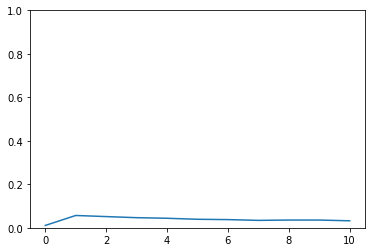

In [35]:
plt.plot([r[-1] for r in results])
plt.ylim(0,1)

In [36]:
# let's get some uncertainty on this...
def bootstrap_bayes_factor(log_acceptance_probabilities, n_bootstrap_samples=10000):
    
    n_01 = len(log_acceptance_probabilities[(0,1)])
    n_10 = len(log_acceptance_probabilities[(1,0)])
    
    if min(n_01, n_10) == 0:
        return np.nan
    
    bayes_factors = []
    for _ in range(n_bootstrap_samples):
    
        mean_acceptance_probability_01 = np.mean(np.exp(log_acceptance_probabilities[(0,1)])[np.random.randint(0, n_01, n_01)])
        mean_acceptance_probability_10 = np.mean(np.exp(log_acceptance_probabilities[(1,0)])[np.random.randint(0, n_10, n_10)])
        bayes_factors.append(mean_acceptance_probability_01 / mean_acceptance_probability_10)
    
    return np.array(bayes_factors)

In [37]:
np.mean(log_acceptance_probabilities[(0,1)]) - np.mean(log_acceptance_probabilities[(1,0)])

-12.434409825420651

In [39]:
bayes_factors = []
for (trajectory, log_acceptance_probabilities, bayes_factor) in results:
    bayes_factors.append(bootstrap_bayes_factor(log_acceptance_probabilities))

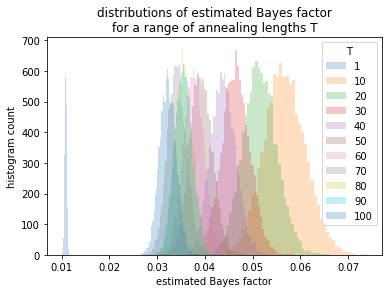

In [40]:
for i in range(len(bayes_factors)):
    plt.hist(bayes_factors[i], bins=50, alpha=0.25, label=str(Ts[i]));
plt.legend(loc='best', title='T')
plt.xlabel('estimated Bayes factor')
plt.ylabel('histogram count')
plt.title('distributions of estimated Bayes factor\nfor a range of annealing lengths T')
plt.savefig('bayes_factor_vs_T.jpg', dpi=300)

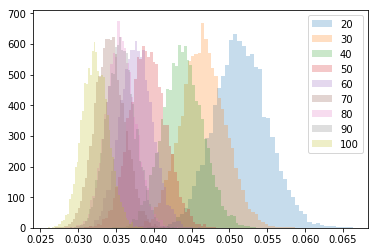

In [41]:
for i in range(len(bayes_factors))[2:]:
    plt.hist(bayes_factors[i], bins=50, alpha=0.25, label=str(Ts[i]));
plt.legend(loc='best')

In [42]:
# sweeet! relatively consistent estimates of the Bayes factor as a function of increasing annealing length
np.percentile(bayes_factors[5], [5,95])

array([0.03540794, 0.04312407])

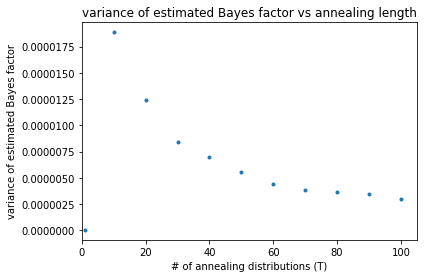

In [44]:
plt.plot(Ts, [np.std(b)**2 for b in bayes_factors], '.')
plt.xlabel('# of annealing distributions (T)')
plt.ylabel('variance of estimated Bayes factor')
plt.xlim(0,)
plt.title('variance of estimated Bayes factor vs annealing length')
plt.savefig('variance_of_bayes_factor_vs_T.jpg', dpi=300, bbox_inches='tight')

(0, 0.0764625053759626)

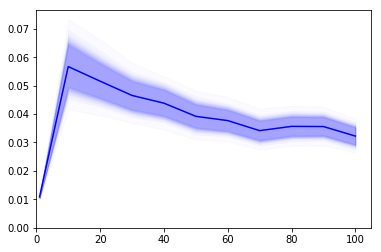

In [63]:
for eps in np.linspace(0.01, 5.0, num=20):
    lbs = []
    ubs = []
    for b in bayes_factors:
        lb, ub = np.percentile(b, [eps, 100.0 - eps])
        lbs.append(lb)
        ubs.append(ub)
    
    plt.fill_between(Ts, lbs, ubs, alpha=1.0 / 50, color='blue')

plt.plot(Ts, [r[-1] for r in results], color='blue')
plt.xlim(0,)
plt.ylim(0,)

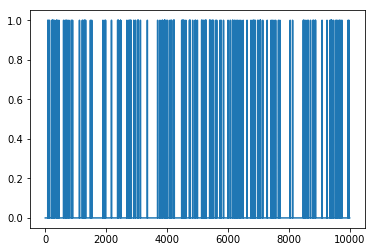

In [50]:
plt.plot([t[1] for t in trajectory])

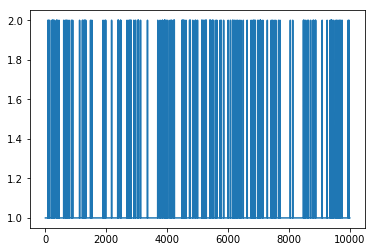

In [51]:
plt.plot([len(t[0]) for t in trajectory])

In [53]:
samples_2d = np.array([t[0] for t in trajectory if len(t[0]) == 2])
samples_2d.shape

(325, 2)

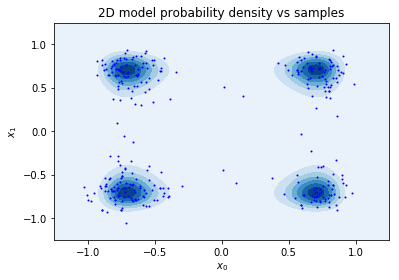

In [112]:
plt.contourf(xs_1d, xs_1d, ys_2d, cmap="Blues")
plt.scatter(samples_2d[:,0], samples_2d[:,1], color='blue', s=1)

plt.xlabel(r'$x_0$')
plt.ylabel(r'$x_1$')
plt.title('2D model probability density vs samples')
plt.savefig('model_2d_comparison.jpg', dpi=300)

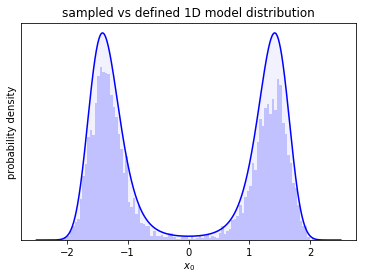

In [118]:
# what about the 1D samples
samples_1d = np.array([t[0] for t in trajectory if len(t[0]) == 1])
plt.plot(xs, ys, color='blue')
plt.fill_between(xs, ys, color='blue', alpha=0.05)

plt.hist(samples_1d, normed=True, bins=100, color='blue', histtype='stepfilled', alpha=0.2);

plt.xlabel(r'$x_0$')
plt.ylabel('probability density')
plt.yticks([])
plt.title('sampled vs defined 1D model distribution')

plt.savefig('model_1d_comparison.jpg', dpi=300)

In [68]:
def get_average_acceptance_probability(log_acceptance_probabilities):
    n_samples = 0
    sum_of_acceptance_probs = 0
    for i in range(2):
        for j in range(2):
            acceptance_probs = np.exp(log_acceptance_probabilities[(i,j)])
            sum_of_acceptance_probs += np.sum(acceptance_probs)
            n_samples += len(acceptance_probs)
    return sum_of_acceptance_probs / n_samples

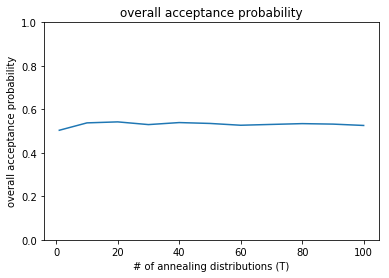

In [119]:
plt.plot(Ts, [get_average_acceptance_probability(r[-2]) for r in results])
plt.ylabel('overall acceptance probability')
plt.xlabel('# of annealing distributions (T)')
plt.ylim(0,1)

plt.title('overall acceptance probability')

plt.savefig('aisrj_acceptance_probability.jpg', dpi=300)

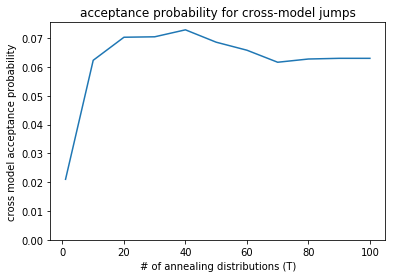

In [102]:
def get_average_cross_model_acceptance_probability(log_acceptance_probabilities):
    n_samples = 0
    sum_of_acceptance_probs = 0
    for i in range(2):
        for j in range(2):
            if i != j:
                acceptance_probs = np.exp(log_acceptance_probabilities[(i,j)])
                sum_of_acceptance_probs += np.sum(acceptance_probs)
                n_samples += len(acceptance_probs)
    return sum_of_acceptance_probs / n_samples

plt.plot(Ts, [get_average_cross_model_acceptance_probability(r[-2]) for r in results])
plt.ylabel('cross model acceptance probability')
plt.xlabel('# of annealing distributions (T)')
plt.ylim(0,)

plt.title('acceptance probability for cross-model jumps')

plt.savefig('aisrj_cross_model_acceptance_probability.jpg', dpi=300)

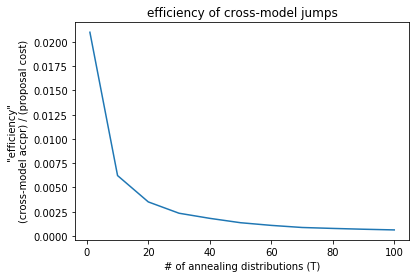

In [103]:
plt.plot(Ts, np.array([get_average_cross_model_acceptance_probability(r[-2]) for r in results]) / np.array(Ts))
plt.xlabel('# of annealing distributions (T)')
plt.ylabel('"efficiency"\n(cross-model accpr) / (proposal cost)')
plt.title('efficiency of cross-model jumps')

plt.savefig('aisrj_cross_model_efficiency.jpg', dpi=300)

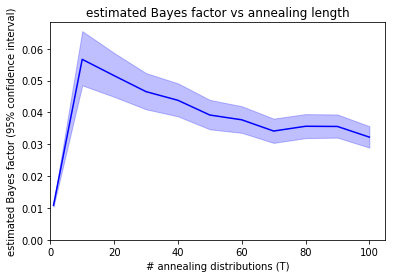

In [100]:
eps = 2.5
lbs = []
ubs = []
for b in bayes_factors:
    lb, ub = np.percentile(b, [eps, 100.0 - eps])
    lbs.append(lb)
    ubs.append(ub)

plt.fill_between(Ts[:len(lbs)], lbs, ubs, alpha=0.25, color='blue')

plt.plot(Ts[:len(lbs)], [r[-1] for r in results], color='blue')
plt.xlim(0,)
plt.ylim(0,)
#plt.yscale('log')

#plt.hlines(ground_truth_bayes_factor, 0, max(Ts[:len(lbs)]), linestyles='--')

plt.xlabel('# annealing distributions (T)')
plt.ylabel('estimated Bayes factor (95% confidence interval)')

plt.title('estimated Bayes factor vs annealing length')
plt.savefig('bayes_factor_vs_T_intervals.jpg', dpi=300)